In [19]:
import re
import json
import emoji
import numpy as np
import pandas as pd
from datetime import *
import datetime as dt
import seaborn as sns
from heatmap import heatmap
import plotly.express as px
from matplotlib import pyplot
from matplotlib.ticker import MaxNLocator
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [20]:
f = open("result.json", mode="r", encoding="utf8")
tele_data = json.load(f)
tele_msgs = tele_data['messages']
df = pd.DataFrame(tele_msgs)
# df.head(10)

In [21]:
## Adding once more cloumn Day for better analysis
weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thrusday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}

df['Dates'] = pd.to_datetime(df['date']).dt.date
df['Dates'] = pd.to_datetime(df["Dates"])
df['Time'] = pd.to_datetime(df['date']).dt.time

df["Day"] = df["Dates"].dt.weekday.map(weeks)

In [22]:
df = df[df.from_id != 'NaN'] 
from_ids = df["from_id"].unique()
for from_id in from_ids:
    df.loc[df.from_id == from_id, 'from']

In [23]:
df[['type','from']].groupby(['from']).count().sort_values(['type'], ascending=False)
df[['media_type', 'id']].groupby('media_type', as_index=False).count()

,media_type,id
0,animation,1
1,audio_file,1
2,sticker,2
3,video_file,15


In [24]:
#Voice message per person
video_df = df.loc[df['media_type'] == 'video_file'][['from', 'id']]\
    .groupby(['from'], as_index=False)\
    .agg('count')\
    .sort_values(['id'], ascending=False)
video_df

,from,id
1,Balaji Venkateshwar,7
0,Abhinav,2
3,Nandan,2
2,Nahh,1
4,Saswat,1
5,Shivraj Kumar,1
6,शाश्वत झा,1


In [25]:
# Video Message per person

fig = px.pie(video_df, hole=.5, values=video_df['id'], names=video_df['from'], title='Video Messages per Person')
fig.update_traces(textposition="inside", textinfo='value+label+percent')
fig.show()

In [26]:
#Emoji 
def get_emojis_in_message(row):
    message = row.text
    emojis = ""
    # Telegram may save some messages as json
    if message is None or type(message) != str:
        return None
    return emojis.join(char for char in message if char in emoji.EMOJI_DATA)

def get_words_count(row):
    message = row.text
    emojis = ""
    # Telegram may save some messages as json
    if message is None or type(message) != str:
        return None
    return re.sub("[^\w]", " ",  message).split().__len__()

df["emojis"] = df[["text"]].apply(get_emojis_in_message, axis=1)
df["word_count"] = df[["text"]].apply(get_words_count, axis=1)

In [27]:
people = df['from'].unique()

for name in people:
    user_df = df[df["from"] == name]
    words_per_message = np.sum(user_df['word_count'])
    # print('stats for ', name)
    # print(name,' sent  ', int(words_per_message), ' words, average ', words_per_message/user_df.shape[0], ' per message')


In [28]:
total_emojis_list = list(df.emojis)
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.replace(to_replace='None', value=np.nan).dropna()
emoji_df.replace(to_replace=0, value=np.nan).dropna()

import plotly.express as px
fig = px.pie(emoji_df.loc[2:].head(60), hole=.5, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

There are 110100 words in all the messages.


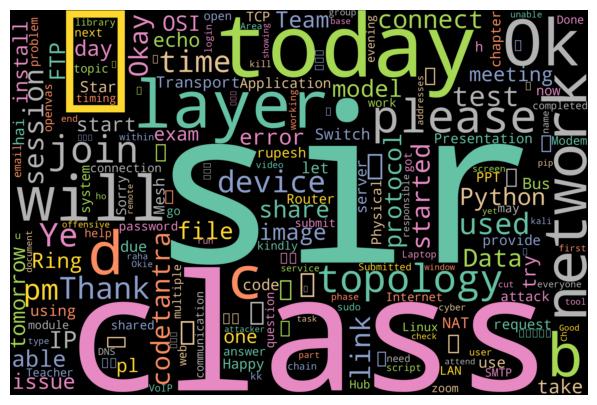

In [29]:
text_df = df.text.dropna()
text = " ".join(review for review in df.text.dropna() if review is not None and type(review) == str)
print ("There are {} words in all the messages.".format(len(text)))

stopwords = set(STOPWORDS)
# stopwords.update(["pero", "en", "que", "lo", "de", "si", "con","se","tengo","por", "la", "el", "ya", "los", "es", "tiene", "como","mi","te","un","esta","del", "tu", "Yo","eso", "pue","para","las","porque","al","bueno","al","donde","ese","son","una","ese","sí","son","le","está","estaba","dice","creo"])
# # Generate a word cloud image
# wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
        background_color='black', colormap='Set2', collocations=False,
        stopwords = stopwords).generate(text)

pyplot.figure( figsize=(10,5))
pyplot.imshow(wordcloud, interpolation ='bilinear')
pyplot.axis("off")
pyplot.show()

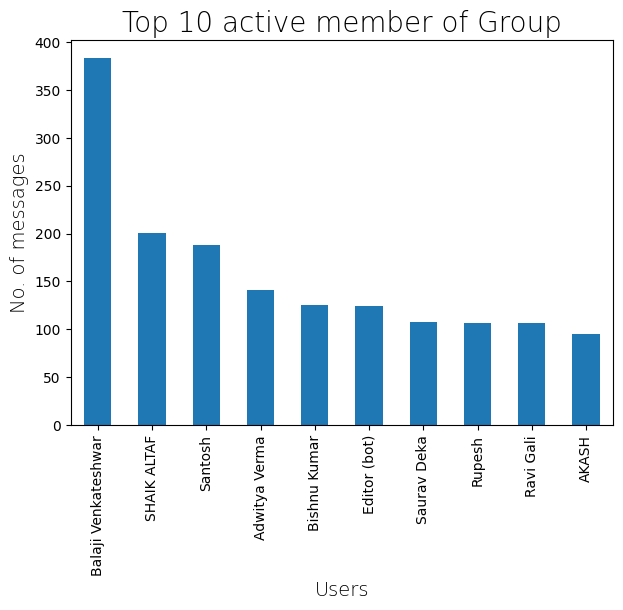

In [30]:
# Let’s check who is the mostly active author of the group : 
### Mostly Active Author in the Group
pyplot.figure(figsize=(7,5))
mostly_active = df['from'].value_counts()
### Top 10 peoples that are mostly active in our Group is : 
m_a = mostly_active.head(10)
user_name  = mostly_active.index
msg_count = mostly_active.values
# x_pos = np.arange(len(bars))
m_a.plot.bar(user_name, msg_count)
pyplot.xlabel('Users',fontdict={'fontsize': 14,'fontweight': 10})
pyplot.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
pyplot.title('Top 10 active member of Group',fontdict={'fontsize': 20,'fontweight': 8})
# pyplot.xticks(x_pos, user_name)
pyplot.show()


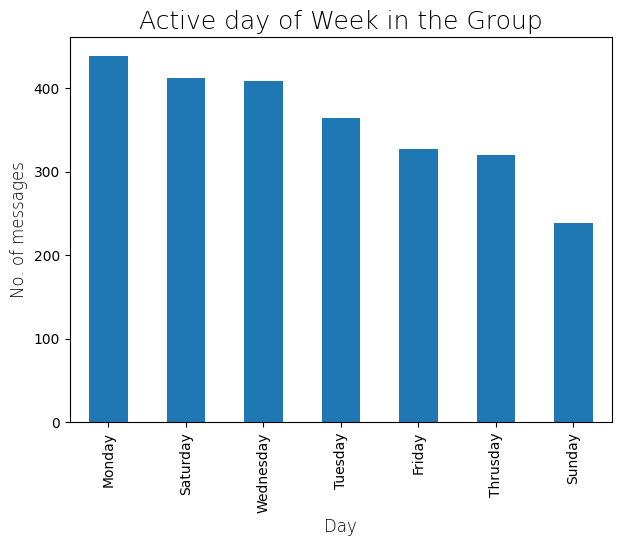

In [31]:
# Mostly active day in the week
pyplot.figure(figsize=(7,5))
active_day = df['Day'].value_counts()
active_day
a_d = active_day.head(10)
a_d.plot.bar()
pyplot.xlabel('Day',fontdict={'fontsize': 12,'fontweight': 10})
pyplot.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
pyplot.title('Active day of Week in the Group',fontdict={'fontsize': 18,'fontweight': 8})
pyplot.show()

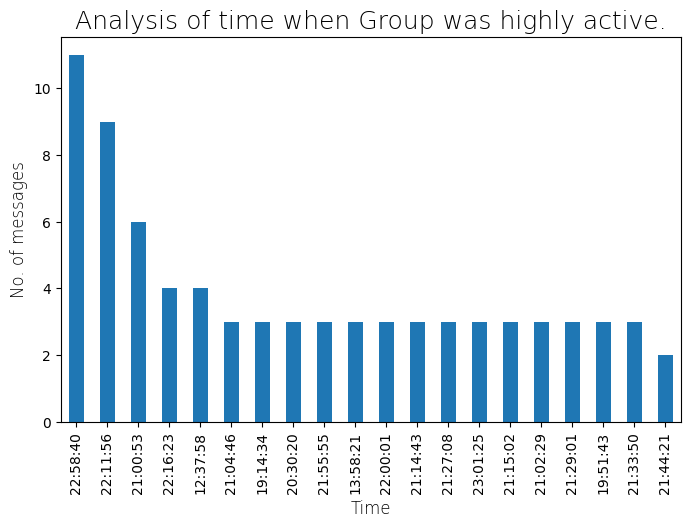

In [32]:
# Check the time whenever the group was highly active : 

pyplot.figure(figsize=(8,5))
time = df["Time"].value_counts().head(20)
tx = time.plot.bar()
tx.yaxis.set_major_locator(MaxNLocator(integer=True))  #Converting y axis data to integer
pyplot.xlabel('Time',fontdict={'fontsize': 12,'fontweight': 10})
pyplot.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
pyplot.title('Analysis of time when Group was highly active.',fontdict={'fontsize': 18,'fontweight': 8})
pyplot.show()

In [33]:
# Time Series plot w.r.t no of message
z = df["Dates"].value_counts()
zDict = z.to_dict() # Convert to Dict
df['msg_count'] = df["Dates"].map(zDict)
#Time Series plot
fig = px.line(x=df['Dates'],y=df['msg_count'])
fig.update_layout(title="Analysis of number of message's using TimeSeries plot.", 
                  xaxis_title='Month',
                  yaxis_title='No. of Messages')
fig.update_xaxes(nticks=20)
fig.show()

In [34]:
# Converting 12-hour formate to 24 hours will help us for better analysis : 

lst = []
out_time = ""
t = ""
for i in df['Time'] :
    t  = i.strftime("%I:%M %p")
    # print(t)
    out_time = datetime.strftime(datetime.strptime(t,"%I:%M %p"),"%H:%M")
    lst.append(out_time)

df['24H_Time'] = lst
df['Hours'] = df['24H_Time'].apply(lambda x : x.split(':')[0])

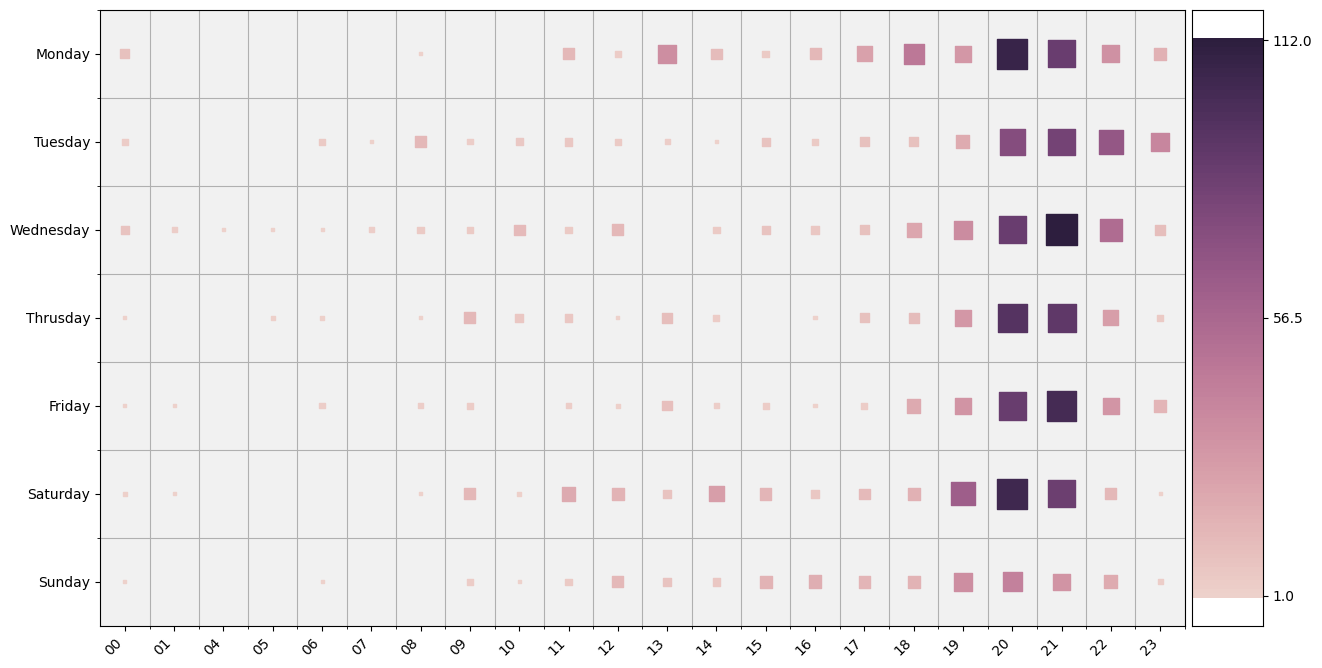

In [35]:
# Heat Map for Highly active Day w.r.t. Time

df2 = df.groupby(['Hours', 'Day'], as_index=False)["text"].count()
df2 = df2.dropna()
df2.reset_index(drop = True,inplace = True)
### Analysing on which time group is mostly active based on hours and day.
analysis_2_df = df.groupby(['Hours', 'Day'], as_index=False)["text"].count()
### Droping null values
analysis_2_df.dropna(inplace=True)
analysis_2_df.sort_values(by=['text'],ascending=False)
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']
pyplot.figure(figsize=(15,8))
heatmap(
    x=analysis_2_df['Hours'],
    y=analysis_2_df['Day'],
    size_scale = 500,
    size = analysis_2_df['text'], 
    y_order = day_of_week[::-1],
    color = analysis_2_df['text'], 
    palette = sns.cubehelix_palette(128)
)
pyplot.show() 

Text(0.5, 1.0, 'Hour vs No. Of Messages')

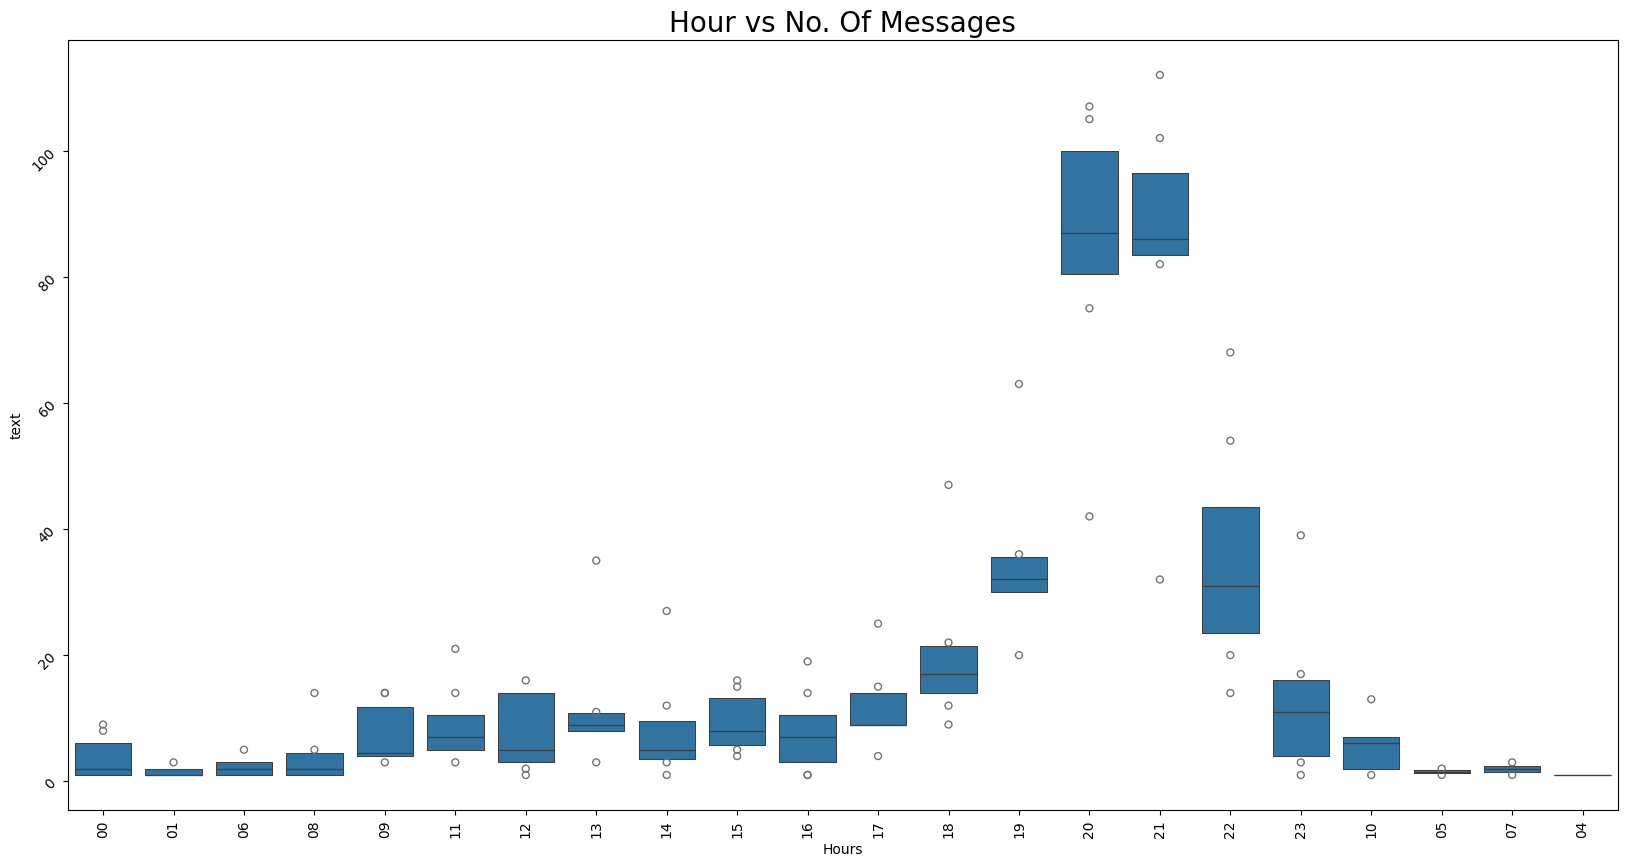

In [36]:
hourdata = df[['Day','Hours','from','text']]
hd = hourdata.groupby(['Day','Hours'], as_index=False)['text'].count()

sns.color_palette("tab10")
sns.color_palette( "Paired")

fig = pyplot.figure(figsize=(20,10))
pyplot.xticks(rotation=90)
pyplot.yticks(rotation=45)
p = sns.boxenplot(x='Hours', y='text', data=hd)
p.set_title('Hour vs No. Of Messages', fontsize = 20)